# Xopt class, TNK test function

This is the class method for running Xopt.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
import torch
from xopt import XoptBase, Evaluator
from xopt.generators.bayesian import MOBOGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, vocs

evaluator = Evaluator(evaluate_TNK)

vocs.constraints = None
generator = MOBOGenerator(vocs, n_initial=20)
print(generator.options)
xopt = XoptBase(generator, evaluator, vocs)
xopt.step()

xopt.history

#for i in range(1):
#    print(f'step {i}')
#    xopt.step()



{'tkwargs': {'dtype': torch.float64, 'device': 'cpu'}, 'n_initial': 20, 'optim_kw': {'num_restarts': 5, 'raw_samples': 20, 'sequential': True}, 'acqf_kw': {'objective': WeightedMCMultiOutputObjective(), 'ref_point': None, 'use_data_as_reference': True}, 'model_kw': {'input_transform': Normalize(), 'outcome_transform': Standardize()}}


,x1,x2,y1,y2,c1,c2,some_array,done
0,1.179109,2.756835,1.179109,2.756835,7.892113,5.554493,"[1, 2, 3]",True
1,2.012852,0.548290,2.012852,0.548290,3.396349,2.291053,"[1, 2, 3]",True
2,2.588870,1.656419,2.588870,1.656419,8.540967,5.700684,"[1, 2, 3]",True
3,0.637061,1.515167,0.637061,1.515167,1.601940,1.049351,"[1, 2, 3]",True
4,2.843219,0.710791,2.843219,0.710791,7.660350,5.535108,"[1, 2, 3]",True
5,0.890600,0.016395,0.890600,0.016395,-0.302258,0.386442,"[1, 2, 3]",True
6,1.204529,2.365784,1.204529,2.365784,6.016465,3.977512,"[1, 2, 3]",True
7,2.853604,3.137297,2.853604,3.137297,16.913004,12.494786,"[1, 2, 3]",True
8,1.736417,1.579495,1.736417,1.579495,4.437233,2.694037,"[1, 2, 3]",True
9,0.583480,2.173820,0.583480,2.173820,4.115344,2.808644,"[1, 2, 3]",True


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


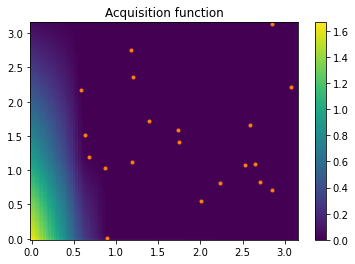

In [2]:
from matplotlib import pyplot as plt# plot model predictions
bounds = generator.get_bounds()
model = generator.get_model()
history = xopt.history

n = 100
x = torch.linspace(*bounds.T[0],n)
y = torch.linspace(*bounds.T[1],n)
xx,yy = torch.meshgrid(x,y)
pts = torch.hstack([ele.reshape(-1,1) for ele in (xx,yy)]).double()


with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = generator.get_acquisition(model)(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx,yy,acq.reshape(n,n))
    fig.colorbar(c)
    ax.set_title('Acquisition function')

    ax.plot(*history[["x1","x2"]].to_numpy().T,'.C1')

In [3]:
generator.options


{'tkwargs': {'dtype': torch.float64, 'device': 'cpu'},
 'n_initial': 20,
 'optim_kw': {'num_restarts': 5, 'raw_samples': 20, 'sequential': True},
 'acqf_kw': {'objective': WeightedMCMultiOutputObjective(),
  'ref_point': [-3.073395289726763, -3.1372971480034364],
  'use_data_as_reference': True},
 'model_kw': {'input_transform': Normalize(),
  'outcome_transform': Standardize()}}